## Consolidating our model runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
sns.set_palette('colorblind')

In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = ati[ati.eye_flag != 3]
kics = ati.KIC.values
print(f'Working with {len(ati)} stars')

Working with 94 stars


Reading in the posterior samples

In [3]:
%%time
d = '/home/oliver/PhD/mnt/RDS/malatium/models_syst/'
post_pa = []
for idx, kic in enumerate(kics):
    try:
        post_pa.append(pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
    except FileNotFoundError:
        print(f'File not found for index {idx}')
        ati.drop(index=idx, inplace=True)
        continue               

File not found for index 58
CPU times: user 20.4 s, sys: 2.9 s, total: 23.2 s
Wall time: 57.2 s


In an ideal world, we would multiply the posterior functions for every star. However we have samples instead of functions. We overcome this by multiplying the probability value in each of 100 bins for all stars, approximating the shape of a combined posterior function.

In [4]:
bins = np.linspace(0, 1, 100)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### The overall result:

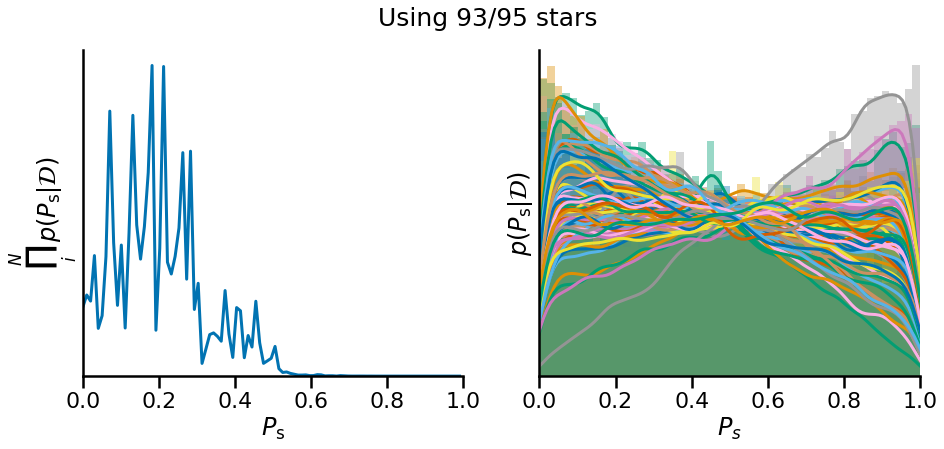

In [5]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], posterior)
# ax[0].set_xlabel('Probability Jen is wrong')
ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(post_pa)}/95 stars', fontsize=25)

plt.show()

### Comparing stellar type

In [6]:
print(ati.hrclass.unique())

['H' 'MS' 'SG']


Set up the classifications:

In [7]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'
print(f'We have {len(ati[sg])} Sub-Giant stars.')
print(f'We have {len(ati[h])} Hot stars.')
print(f'We have {len(ati[ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 23 Hot stars.
We have 66 Main-Sequence stars.


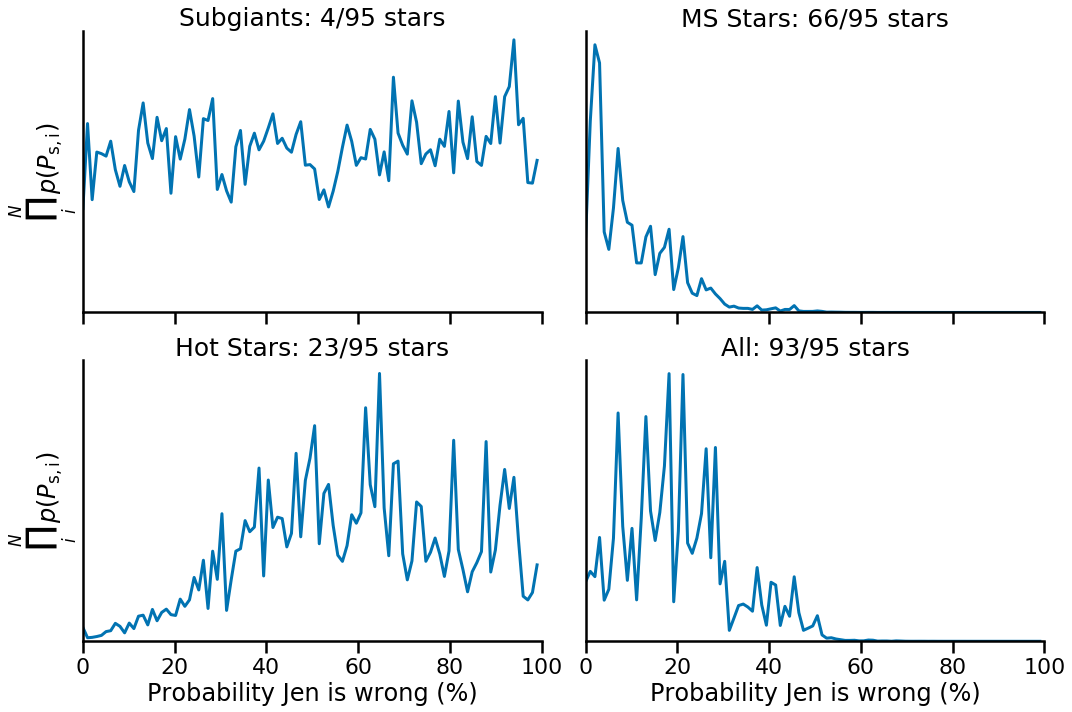

In [8]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists[sg])}/95 stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)

ax[1].plot(bins[:-1], np.prod(hists[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists[ms])}/95 stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0)

ax[2].plot(bins[:-1], np.prod(hists[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists[h])}/95 stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0)

ax[3].plot(bins[:-1], np.prod(hists, axis=0))
ax[3].set_title(fr'All: {len(hists)}/95 stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(0)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

Here I've plotted the combined posterior probabilities for stars in certain evolutionary groups.

- MS stars are strongly in favour of a critical Rossby number. This should be enough to satisfy anybody looking for a `smoking gun` in these rotation rates.
- Hot stars and Subgiant stars have relatively little to contribute.
- Its curious that hot stars seem to explicitly favour a **mixture** of the two models, which can likely be attributed to falling out of the active range of the KDE.

### A conservative check on KDE membership

Since Jen's 2019 models were intended only really to look at stars below the Kraft break, there may be some stars that were included in the posterior estimation, but weren't properly represented in Jen's models.

To mitigate this, I'll make a selection to remove any stars that weren't directly inside the parameter spaces of the two models.

In [9]:
stan = pd.read_csv('../data/jvs_models/standard_model.csv')
ro = pd.read_csv('../data/jvs_models/rocrit_model.csv')

In [10]:
cols = ['# Teff(K)', ' Prot(days)', ' Age(Gyr)', ' Mass(Msun)']
bound_s = [(stan[par].min(), stan[par].max()) for par in cols]
cols = ['#Teff(K)', ' Prot(days)', ' Age(Gyr)', ' Mass(Msun)']
bound_ro = [(ro[par].min(), ro[par].max()) for par in cols]

In [11]:
c1 = ati.copy(deep=True)
sel = []

cols = ['Teff', 'P', 'age', 'modmass']
for idx in c1.index:
    par = [c1.loc[idx][col] for col in cols]
    if not all(b[0] < v < b[1] for v, b in list(zip(par, bound_s))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    elif not all(b[0] < v < b[1] for v, b in list(zip(par, bound_ro))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    else:
        sel.append(True)
        pass

In [12]:
hists_sel = hists[sel]
sg = c1['hrclass'] == 'SG'
ms = c1['hrclass'] == 'MS'
h = c1['hrclass'] == 'H'
print(f'We have {len(c1[sg])} Sub-Giant stars.')
print(f'We have {len(c1[h])} Hot stars.')
print(f'We have {len(c1[ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 16 Hot stars.
We have 55 Main-Sequence stars.


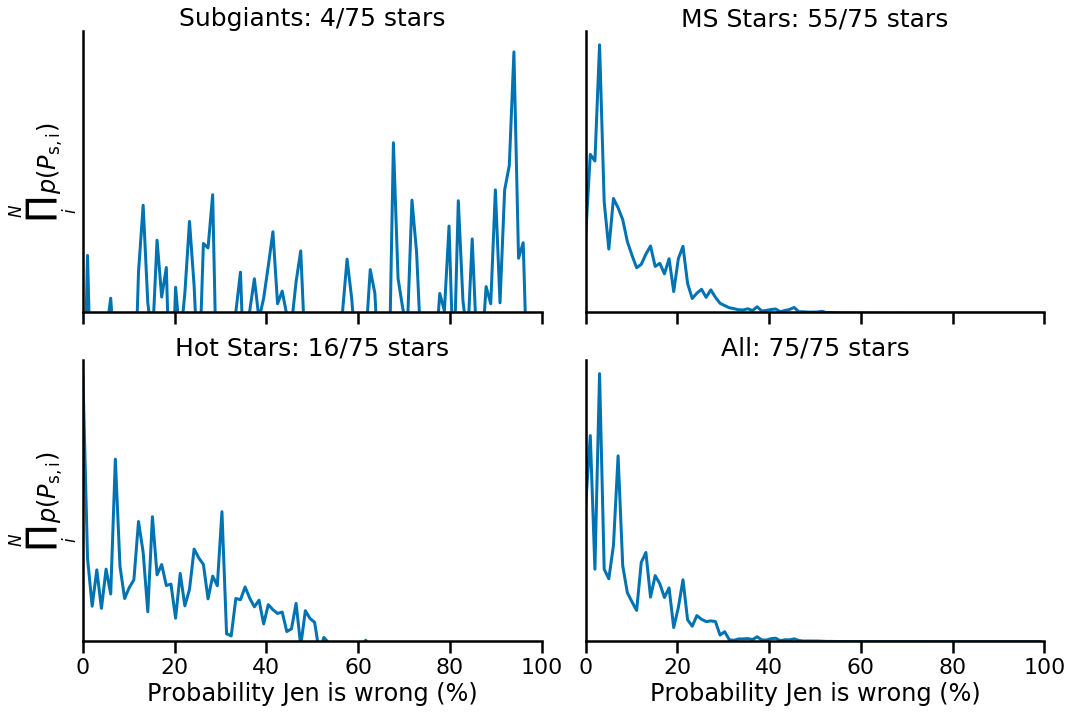

In [13]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel[sg])}/{len(c1)} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(1)

ax[1].plot(bins[:-1], np.prod(hists_sel[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel[ms])}/{len(c1)} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(1)

ax[2].plot(bins[:-1], np.prod(hists_sel[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel[h])}/{len(c1)} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(1)

ax[3].plot(bins[:-1], np.prod(hists_sel, axis=0))
ax[3].set_title(fr'All: {len(hists_sel)}/{len(c1)} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

When removing outlier stars, the result is still maintained. With MS stars only, magnetic braking is still the most probably outcome, fortunately.

Some things to note:
- Now we're only include Hot stars in the KDE range, we see that they mostly agree with magnetic braking. Could this be interpreted as the Kraft Break lying at higher temperatures, or is it a coincidence?
- Can we increase the scope of the models to include later ages?
- Can we ensure both models capture the same temperature range?

### A check on convergence 

While we appear to have decent convergence on all parameters, there are some with low numbers of effective samples, or Rhat values that are high enough to raise eyebrows a little. We'll run the same checks, but with those removed.

We'll remove all stars with:
- Any of the core 4 parameters outside the KDE range (as in the example above)
- $n_{\rm eff} < 1000$ on splitting.
- $\hat{R} > 1.1$ on a rotational parameter.

In [14]:
c2 = c1.copy(deep=True)
sel = (c2.neff_split > 1000) & (c2.rhat_flag != 'rhat_1')
hists_sel_cov = hists_sel[sel]
sg = c2[sel]['hrclass'] == 'SG'
ms = c2[sel]['hrclass'] == 'MS'
h = c2[sel]['hrclass'] == 'H'
print(f'We have {len(c2[sel][sg])} Sub-Giant stars.')
print(f'We have {len(c2[sel][h])} Hot stars.')
print(f'We have {len(c2[sel][ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 15 Hot stars.
We have 45 Main-Sequence stars.


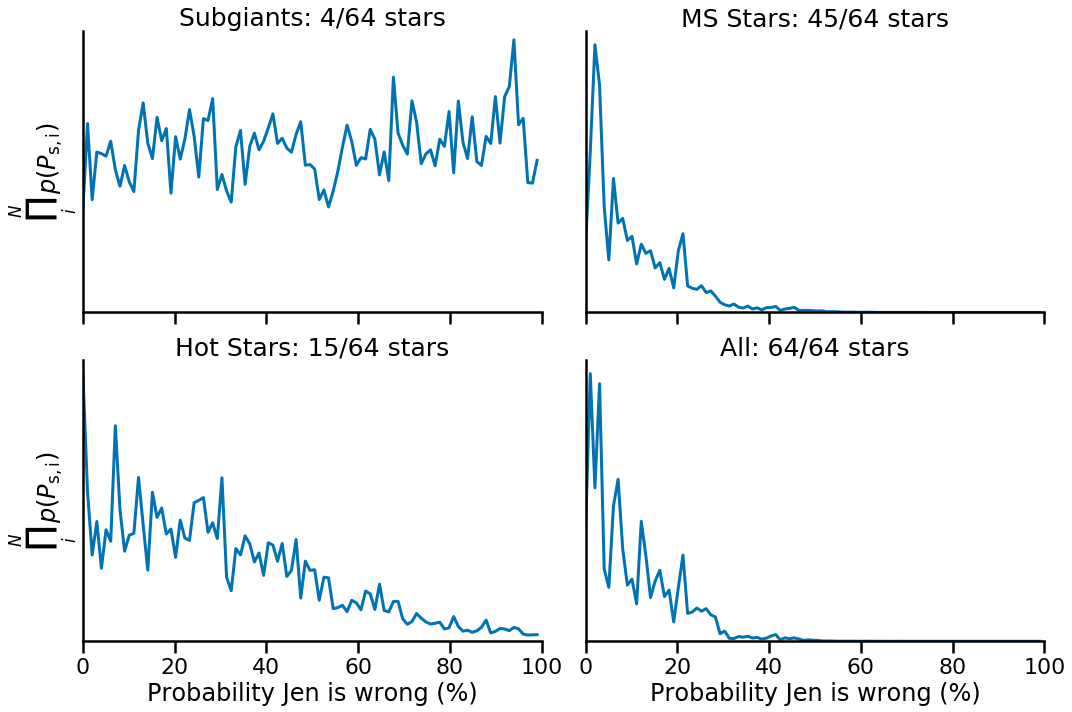

In [15]:
fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel_cov[sg])}/{len(c2[sel])} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)

ax[1].plot(bins[:-1], np.prod(hists_sel_cov[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel_cov[ms])}/{len(c2[sel])} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0)

ax[2].plot(bins[:-1], np.prod(hists_sel_cov[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel_cov[h])}/{len(c2[sel])} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0)

ax[3].plot(bins[:-1], np.prod(hists_sel_cov, axis=0))
ax[3].set_title(fr'All: {len(hists_sel_cov)}/{len(c2[sel])} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(0)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

In [16]:
fsel = ati['KIC'].isin(c2[sel]['KIC'])
f_post_pa = np.array(post_pa)[fsel]

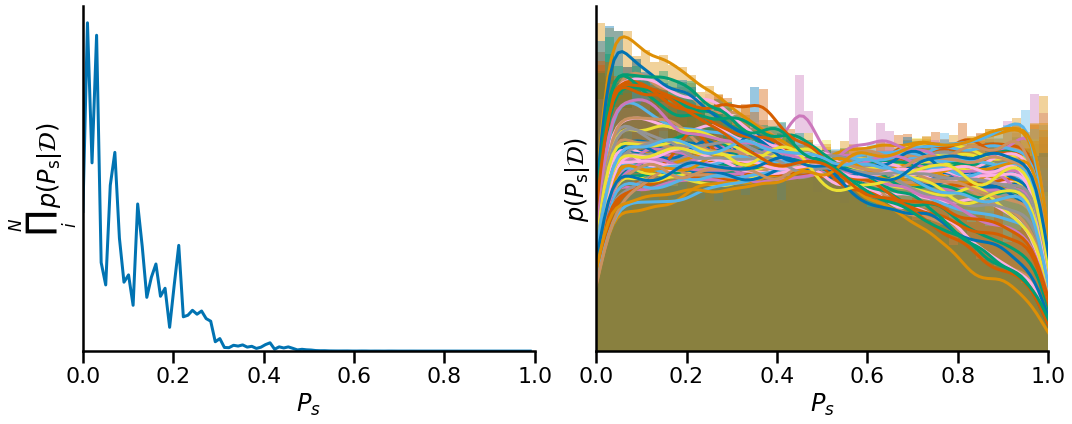

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov, axis=0))
# ax[0].set_xlabel('Probability vS+16 is wrong')
ax[0].set_xlabel(r'$P_s$')
# ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
# ax[1].set_ylim(0)
ax[1].get_yaxis().set_ticks([])
sns.despine()

# fig.suptitle(fr'Using {len(hists_sel_cov)}/95 stars', fontsize=25)
fig.tight_layout()
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/modelresults_syst.pdf', rasterized=True)
plt.show()